In [1]:
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter, find_peaks
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
def create_signals_dataset(path):
    fs = 4
    cols_data = []
    fhr_features = []
    index = []

    files = sorted([f for f in os.listdir(path) if f.endswith(".csv")])

    for file in files:
        file_path = os.path.join(path, file)
        df = pd.read_csv(file_path, sep=",")

        df["FHR"] = df["FHR"].replace(0, np.nan).interpolate().fillna(0)
        df["UC"] = df["UC"].replace(0, np.nan).interpolate().fillna(0)

        FHR_col = savgol_filter(df["FHR"].values, 200, 3)
        UC_col = savgol_filter(df["UC"].values, 200, 3)
        s_col = np.arange(len(df["seconds"].values)) / fs

        cols_data.append([s_col, FHR_col, UC_col])
        index.append(file.replace(".csv", ""))

        (
            mean_fhr,
            normal_fhr,
            num_accelerations,
            num_decelerations,
            min_fhr,
            max_fhr,
            num_peaks,
            std_dev_fhr,
        ) = calculate_fhr_metrics(FHR_col)
        fhr_features.append(
            [
                mean_fhr,
                normal_fhr,
                num_accelerations,
                num_decelerations,
                min_fhr,
                max_fhr,
                num_peaks,
                std_dev_fhr,
            ]
        )
    SIGNALS_DF = pd.DataFrame(cols_data, columns=df.columns.values, index=index)
    FEATURES_FHR_DF = pd.DataFrame(
        fhr_features,
        columns=[
            "mean_fhr",
            "normal_fhr",
            "num_accelerations_fhr",
            "num_decelerations_fhr",
            "min_fhr",
            "max_fhr",
            "num_peaks_fhr",
            "std_dev_fhr",
        ],
        index=index,
    )
    return SIGNALS_DF, FEATURES_FHR_DF


def calculate_fhr_metrics(fhr_values):
    # Media de la frecuencia cardíaca normal (110-160 lpm)
    mean_fhr = np.mean(fhr_values)
    normal_fhr = 1 if mean_fhr >= 110 and mean_fhr <= 160 else 0

    # Contar el número de aceleraciones y desaceleraciones
    accelerations = [
        val for i, val in enumerate(fhr_values[1:], 1) if val - fhr_values[i - 1] >= 15
    ]
    decelerations = [
        val for i, val in enumerate(fhr_values[1:], 1) if fhr_values[i - 1] - val >= 15
    ]
    num_accelerations = len(accelerations)
    num_decelerations = len(decelerations)

    # Valor mínimo y máximo global
    min_fhr = np.min(fhr_values)
    max_fhr = np.max(fhr_values)

    # Contar el número de picos
    peaks, _ = find_peaks(fhr_values)
    num_peaks = len(peaks)

    # Desviación estándar
    std_dev_fhr = np.std(fhr_values)

    return (
        mean_fhr,
        normal_fhr,
        num_accelerations,
        num_decelerations,
        min_fhr,
        max_fhr,
        num_peaks,
        std_dev_fhr,
    )

#### **Conjunto de datos de entrenamiento y de pruebas con las señales FHR Y UC**

In [3]:
TRAIN_PATH = "./data/signals/train/"
TEST_PATH = "./data/signals/test/"

train_signals_df, train_features_df = create_signals_dataset(TRAIN_PATH)
test_signals_df, test_features_df = create_signals_dataset(TEST_PATH)

In [4]:
train_signals_df.head()

,seconds,FHR,UC
5002,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[125.79954772909103, 126.1512853674876, 126.49...","[6.975518082173635, 6.971212586285128, 6.96665..."
5003,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[116.95482727197071, 117.07175038901416, 117.1...","[25.785611665129455, 25.775700212153648, 25.76..."
5005,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[151.67827425691624, 152.0507333769893, 152.41...","[42.402698796899784, 42.566633444941644, 42.72..."
5006,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[130.35000820411426, 130.5571024449305, 130.76...","[15.897514917729557, 15.781976577751768, 15.66..."
5007,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [5]:
test_signals_df.head()

,seconds,FHR,UC
5001,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[152.01467823056106, 151.84534402366543, 151.6...","[2.0223411790484143, 1.83961821510542, 1.66311..."
5004,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[132.49743111006933, 132.54606620649471, 132.5...","[128.45508741713084, 128.24163370805, 128.0285..."
5010,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5012,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5020,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[146.05796219251363, 146.13748425567616, 146.2...","[26.45142196154769, 26.339823506902007, 26.230..."


#### **Visualización del filtrado de la señal**

In [ ]:
file = "5552"
seconds = train_signals_df.loc[file]["seconds"]
FHR = train_signals_df.loc[file]["FHR"]
UC = train_signals_df.loc[file]["UC"]

# Convertir segundos a minutos
minutes = seconds / 60

# Crear la figura
plt.figure(figsize=(15, 5))

fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
fig.tight_layout(pad=3.0)

# Graficar FHR en el primer subplot
axs[0].plot(minutes, FHR, label="FHR", color="g")
for minute in range(0, int(max(minutes)), 10):
    axs[0].axvline(x=minute, color="b", linestyle="--", linewidth=1)
axs[0].set_title(f"{file} - FHR")
axs[0].set_ylabel("FHR [lpm]")
axs[0].set_xticks(range(0, int(max(minutes)), 10))
axs[0].legend()
axs[0].grid()

# Graficar UC en el segundo subplot
axs[1].plot(minutes, UC, label="UC", color="r")
for minute in range(0, int(max(minutes)), 10):
    axs[1].axvline(x=minute, color="b", linestyle="--", linewidth=1)
axs[1].set_title(f"{file} - UC")
axs[1].set_xlabel("Time (min)")
axs[1].set_ylabel("UC [mmHg]")
axs[1].set_xticks(range(0, int(max(minutes)), 10))
axs[1].legend()
axs[1].grid()

# Mostrar la figura
plt.show()

In [102]:
train_features_dataset = (
    pd.read_csv("./data/train.csv", sep=",")
    .sort_values("recordID")
    .drop("recordID", axis=1)
)
test_features_dataset = (
    pd.read_csv("./data/test.csv", sep=",")
    .sort_values("recordID")
    .drop("recordID", axis=1)
)

In [103]:
metadata_train = pd.concat(
    [
        train_features_dataset.reset_index(drop=True),
        train_features_df.reset_index(drop=True),
    ],
    axis=1,
)
metada_test = pd.concat(
    [
        test_features_dataset.reset_index(drop=True),
        test_features_df.reset_index(drop=True),
    ],
    axis=1,
)

In [94]:
metadata_train

,babyhealth,gestweeks,sex,age,gravidity,parity,diabetes,hypertension,preeclampsia,pyrexia,...,noprogress,rectype,mean_fhr,normal_fhr,num_accelerations_fhr,num_decelerations_fhr,min_fhr,max_fhr,num_peaks_fhr,std_dev_fhr
0,0,41.0,1.0,29.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,128.956169,1,0,0,53.329177,157.036977,262,20.107769
1,0,40.0,2.0,26.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,12.0,126.737147,1,0,0,95.298830,169.039675,410,8.870874
2,0,41.0,1.0,36.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,12.0,134.186668,1,0,0,56.833641,165.929995,303,20.959831
3,0,38.0,1.0,28.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,12.0,125.751155,1,0,0,56.893042,146.751128,323,14.975236
4,0,39.0,1.0,34.0,3.0,1.0,1.0,0.0,0.0,0.0,...,0.0,12.0,127.851435,1,0,0,-12.222221,158.201078,275,25.314994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,0,38.0,1.0,33.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,127.001165,1,0,0,80.257915,176.981264,265,13.555102
382,0,38.0,1.0,36.0,5.0,3.0,1.0,1.0,0.0,0.0,...,0.0,1.0,144.529038,1,0,0,126.899209,168.817182,404,6.280792
383,0,40.0,1.0,33.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,135.181431,1,0,0,64.575460,191.089530,219,19.286478
384,0,41.0,1.0,36.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,12.0,148.855210,1,0,0,81.260775,170.925166,189,15.192994


In [104]:
metada_test

,gestweeks,sex,age,gravidity,parity,diabetes,hypertension,preeclampsia,pyrexia,meconium,noprogress,rectype,mean_fhr,normal_fhr,num_accelerations_fhr,num_decelerations_fhr,min_fhr,max_fhr,num_peaks_fhr,std_dev_fhr
0,42.0,2.0,34.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,139.623419,1,0,0,75.093636,166.747388,278,16.571913
1,39.0,1.0,24.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,132.440914,1,0,0,81.471385,225.577673,215,15.182035
2,41.0,2.0,25.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,120.379514,1,0,0,-8.424576,171.338850,345,51.420169
3,41.0,1.0,33.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,138.814949,1,0,0,-9.170356,181.771908,310,37.472932
4,42.0,2.0,31.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,137.274844,1,0,0,80.984672,157.572320,247,17.975823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,41.0,1.0,35.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,140.258346,1,0,0,63.600117,169.662409,455,15.794370
162,42.0,1.0,30.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,126.126832,1,0,0,45.182989,158.773452,242,23.280821
163,40.0,2.0,32.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,135.921196,1,0,0,93.860223,187.751163,328,12.212704
164,40.0,2.0,29.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,136.082498,1,0,0,56.731181,173.039724,229,27.230174


#### **Datos estadísticos de los metadatos**

In [105]:
metadata_train.describe()

,babyhealth,gestweeks,sex,age,gravidity,parity,diabetes,hypertension,preeclampsia,pyrexia,...,noprogress,rectype,mean_fhr,normal_fhr,num_accelerations_fhr,num_decelerations_fhr,min_fhr,max_fhr,num_peaks_fhr,std_dev_fhr
count,386.000000,386.000000,386.000000,386.000000,384.000000,386.000000,386.000000,386.000000,386.000000,386.000000,...,386.000000,384.000000,386.000000,386.000000,386.0,386.0,386.000000,386.000000,386.000000,386.000000
mean,0.194301,39.927461,1.448187,29.707254,1.455729,0.417098,0.072539,0.080311,0.025907,0.012953,...,0.103627,1.940104,130.668828,0.904145,0.0,0.0,50.275012,175.096592,292.914508,22.051807
std,0.396175,1.182084,0.497954,4.608834,1.028634,0.785993,0.259715,0.272127,0.159063,0.113220,...,0.305172,2.794821,13.616324,0.294774,0.0,0.0,40.935055,18.156222,88.402330,12.258588
min,0.000000,37.000000,1.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,85.789311,0.000000,0.0,0.0,-47.587357,128.504049,108.000000,4.468977
25%,0.000000,39.000000,1.000000,27.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,122.301908,1.000000,0.0,0.0,-7.993955,163.568088,230.000000,14.059222
50%,0.000000,40.000000,1.000000,30.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,130.923105,1.000000,0.0,0.0,62.444356,172.844693,277.000000,18.102912
75%,0.000000,41.000000,2.000000,33.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,139.628795,1.000000,0.0,0.0,77.759426,184.287233,344.000000,24.658031
max,1.000000,43.000000,2.000000,42.000000,8.000000,7.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,12.000000,170.729771,1.000000,0.0,0.0,132.081657,288.950137,580.000000,65.258010


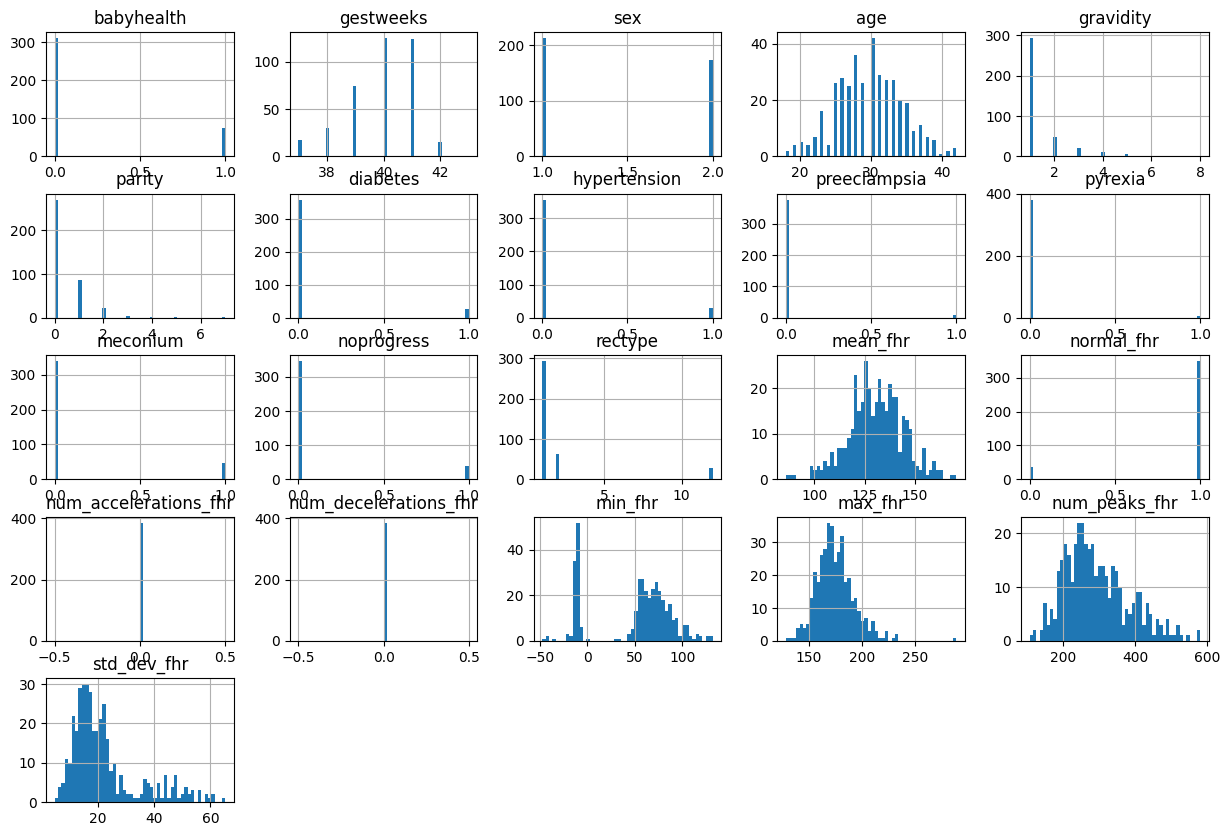

In [106]:
metadata_train.hist(figsize=(15, 10), bins=50)
plt.show()

In [107]:
corr_matrix = metadata_train.corr()
corr_matrix["babyhealth"].sort_values(ascending=False)

babyhealth               1.000000
std_dev_fhr              0.103292
noprogress               0.090833
max_fhr                  0.072544
hypertension             0.023531
gestweeks                0.013535
age                     -0.007175
mean_fhr                -0.010203
normal_fhr              -0.018035
sex                     -0.021250
min_fhr                 -0.034426
diabetes                -0.036362
rectype                 -0.038850
preeclampsia            -0.038868
meconium                -0.042691
pyrexia                 -0.056257
num_peaks_fhr           -0.080807
gravidity               -0.090670
parity                  -0.144158
num_accelerations_fhr         NaN
num_decelerations_fhr         NaN
Name: babyhealth, dtype: float64

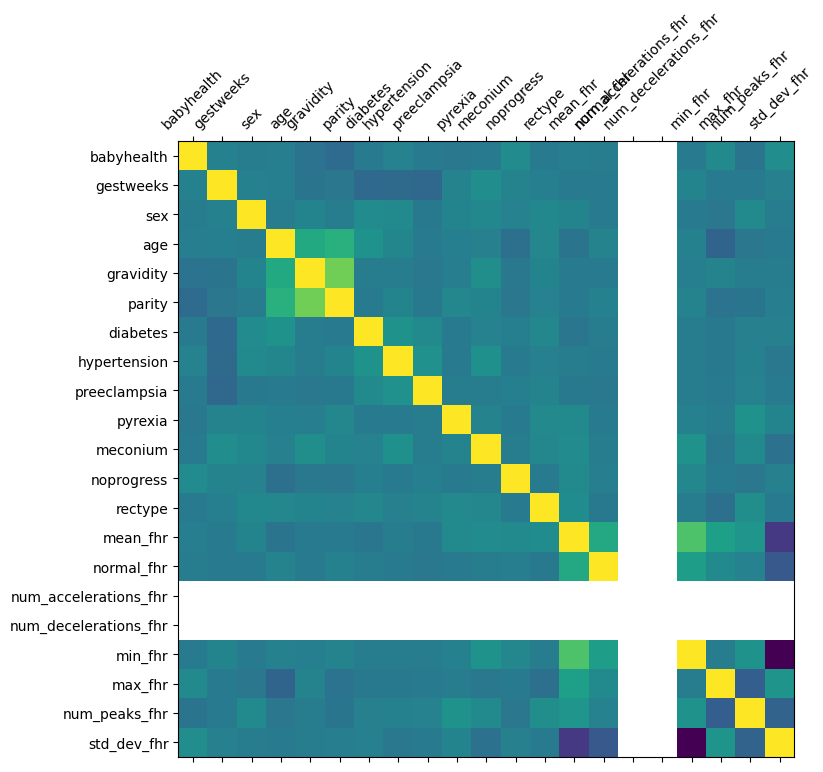

In [98]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(corr_matrix)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.show()

#### **Conjunto de datos de entrenamiento**

In [108]:
y_train = metadata_train["babyhealth"].reset_index(drop=True)
features_train = metadata_train.drop(columns=["babyhealth", "sex"]).reset_index(
    drop=True
)
x_train = features_train

In [109]:
y_train

0      0
1      0
2      0
3      0
4      0
      ..
381    0
382    0
383    0
384    0
385    0
Name: babyhealth, Length: 386, dtype: int64

In [110]:
x_train.head()

,gestweeks,age,gravidity,parity,diabetes,hypertension,preeclampsia,pyrexia,meconium,noprogress,rectype,mean_fhr,normal_fhr,num_accelerations_fhr,num_decelerations_fhr,min_fhr,max_fhr,num_peaks_fhr,std_dev_fhr
0,41.0,29.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,128.956169,1,0,0,53.329177,157.036977,262,20.107769
1,40.0,26.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12.0,126.737147,1,0,0,95.298830,169.039675,410,8.870874
2,41.0,36.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12.0,134.186668,1,0,0,56.833641,165.929995,303,20.959831
3,38.0,28.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,12.0,125.751155,1,0,0,56.893042,146.751128,323,14.975236
4,39.0,34.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,12.0,127.851435,1,0,0,-12.222221,158.201078,275,25.314994


#### **Conjunto de datos de prueba**

In [116]:
features_test = metada_test.drop(columns=["sex"]).reset_index(drop=True)
x_test = features_test

In [117]:
x_test.head()

,gestweeks,age,gravidity,parity,diabetes,hypertension,preeclampsia,pyrexia,meconium,noprogress,rectype,mean_fhr,normal_fhr,num_accelerations_fhr,num_decelerations_fhr,min_fhr,max_fhr,num_peaks_fhr,std_dev_fhr
0,42.0,34.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,139.623419,1,0,0,75.093636,166.747388,278,16.571913
1,39.0,24.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,132.440914,1,0,0,81.471385,225.577673,215,15.182035
2,41.0,25.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,120.379514,1,0,0,-8.424576,171.338850,345,51.420169
3,41.0,33.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,138.814949,1,0,0,-9.170356,181.771908,310,37.472932
4,42.0,31.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,137.274844,1,0,0,80.984672,157.572320,247,17.975823
